In [1]:
import python_functions
import params_scrap_syride

import zipfile
import os
import time
import requests
import json
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.remote.webelement import WebElement

%load_ext autoreload
%autoreload 2

In [2]:
pilotes = params_scrap_syride.pilots
main_path = params_scrap_syride.main_path

In [8]:
path=main_path
base_url: str = "https://www.syride.com/fr/pilotes/"
pilot="AdrienM"
pilote=pilot


repertoire_pilote = path + pilot
list_of_known_traces = python_functions.initiate_search(main_repertoire=repertoire_pilote)
known_traces=list_of_known_traces

Dossiers trouvés, 55 trace(s) déjà téléchargée(s).


In [5]:
#new_navs, dict_navs = python_functions.get_all_navs(pilote=pilot, known_traces=list_of_known_traces)

In [6]:
base_url: str = "https://www.syride.com/fr/pilotes/"
pilote=pilot
known_traces=list_of_known_traces


# Configuration de Selenium
chrome_options = Options()
chrome_options.add_argument(
    "--headless"
)  # Exécuter le navigateur en mode headless (sans interface graphique)
# service = Service(
#     "/Users/Adrien/Documents/paramoteur/syride/analyze_traces/chromedriver-mac-x64/chromedriver"
# )
# driver = webdriver.Chrome(service=service, options=chrome_options)
driver = webdriver.Chrome(options=chrome_options)

url = base_url + pilote
dict_navs = {}

driver.get(url)

if len(known_traces) >= 50:
    nb_scroll = 5
else:
    nb_scroll = 10
# Faire défiler jusqu'en bas de la page
python_functions.scroll_to_bottom(driver, nb_scroll=nb_scroll)

activities = driver.find_elements(
    By.XPATH, "//*[contains(@id, 'activite') and string-length(@id)=15]"
)

Scrolling (total : 10)...
1 2 3 4 5 6 7 8 9 10 


In [17]:
for i, activity in enumerate(activities):
    print(i+1, end="", flush=True)
    num_activite, dict_activity = python_functions.get_nav_infos1(
        activity=activity, pilote=pilote
    )
    dict_navs[f"{num_activite}"] = dict_activity
print("")

1

photo_gps_element
2photo_gps_element
3photo_gps_element
4photo_gps_element
5photo_gps_element
6photo_gps_element
7photo_gps_element
8photo_gps_element
9photo_gps_element
10photo_gps_element
11photo_gps_element
12photo_gps_element
13photo_gps_element
14photo_gps_element
15photo_gps_element
16photo_gps_element
17photo_gps_element
18photo_gps_element
19photo_gps_element
20photo_gps_element
21photo_gps_element
22photo_gps_element
23photo_gps_element
24photo_gps_element
25photo_gps_element
26photo_gps_element
27photo_gps_element
28photo_gps_element
29photo_gps_element
30photo_gps_element
31photo_gps_element
32photo_gps_element
33photo_gps_element
34photo_gps_element
35photo_gps_element
36photo_gps_element
37photo_gps_element
38photo_gps_element
39photo_gps_element
40photo_gps_element
41photo_gps_element
42photo_gps_element
43photo_gps_element
44photo_gps_element
45photo_gps_element
46photo_gps_element
47photo_gps_element
48photo_gps_element
49photo_gps_element
50photo_gps_element
51photo_gp

TypeError: catching classes that do not inherit from BaseException is not allowed

In [ ]:
for activity in activities:
    try:
        num_activite, dict_activity = python_functions.get_nav_infos1(
            activity=activity, pilote=pilote
        )
        dict_navs[f"{num_activite}"] = dict_activity
    except:
        print(activity)
        pass

dict_navs = {
    key: value for key, value in dict_navs.items() if key not in known_traces
}

final_list = list(set(dict_navs.keys()))

print(f"{len(final_list)} nouvelles traces trouvées.")

#driver.quit()

In [ ]:
if len(new_navs) > 0:
    print(f"Réupération des liens (total {len(new_navs)})...")
    dict_links = python_functions.get_zip_adresses(pilote=pilot, traces=new_navs)

    print("")
    print(f"Téléchargement des traces (total {len(dict_links)})...")
    for i, dict_item in enumerate(dict_links.items()):
        nav = dict_item[0]
        link = dict_item[1]
        print(f"{i+1} ", end="", flush=True)
        python_functions.download_traces(main_repertoire=repertoire_pilote, nav=nav, link=link)
else:
    print("Pas de nouvelles traces a telecharger.")

In [3]:
from pykml import parser

In [8]:
kml_file = "/Users/Adrien/Documents/paramoteur/syride/analyze_traces/syride_traces/AdrienM/traces/1914899/1914899.kml"
with open(kml_file, 'r') as f:
    root = parser.parse(f)


In [ ]:
from lxml import etree

# Charger le contenu du fichier .kml avec lxml
with open(kml_file, 'r') as f:
    doc = etree.parse(f)

# Définir les espaces de noms utilisés dans le fichier .kml
namespaces = {
    'kml': 'http://www.opengis.net/kml/2.2',
}

# Parcourir et explorer les données
for placemark in doc.findall('.//kml:Document', namespaces=namespaces):
    name_element = placemark.find('kml:name', namespaces=namespaces)
    name = name_element.text if name_element is not None else "Pas de nom"

    description_element = placemark.find('kml:Style/kml:LineStyle/kml:color', namespaces=namespaces)
    description = description_element.text if description_element is not None else "Pas de description"

    point_element = placemark.find('kml:Placemark/kml:LineString/kml:coordinates', namespaces=namespaces)
    coordinates = point_element.text if point_element is not None else "Pas de coordonnées"

    print(f"Nom : {name}")
    print(f"Couleur de la ligne : {description}")
    print(f"Coordonnées : {coordinates}\n")


In [85]:
coordinates

'Pas de coordonnées'

In [68]:
import geopandas as gpd
import fiona
import pandas as pd

fiona.drvsupport.supported_drivers['libkml'] = 'rw'
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'

gdf_list = []
for layer in fiona.listlayers(kml_file):  
    print(layer)
    gdf = gpd.read_file(kml_file, driver='LIBKML', layer=layer)
    gdf_list.append(gdf)

gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
gdf

Flight of Adrien Moreau recorded with Syride 1420171135


,Name,Description,geometry
0,,,"LINESTRING Z (0.17093 45.55932 150.00000, 0.17..."


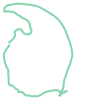

In [82]:
#help(gdf.geometry)
gdf_list[0].iloc[0]['geometry']

In [3]:
import zipfile
import os
import time
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.remote.webelement import WebElement

In [4]:
def extract_site(text:str) -> str:
    # Trouver l'index du premier "à" dans la chaîne
    index_de_a = text.find("à")

    # Trouver l'index de la première parenthèse ouvrante "(" après le premier "à"
    index_premiere_parenthese = text.find("(", index_de_a)

    # Extraire le texte entre le premier "à" et la première parenthèse
    texte_extrait = text[index_de_a + 1 : index_premiere_parenthese].strip()

    return(texte_extrait)

def extract_date_heure(date_h_data:str, date_hour:str) -> str:
    date_h_temp = date_h_data.split(":")[1]
    date_h = date_h_temp.split(" ")
    if date_hour == "date":
        return date_h[1]
    else:
        return date_h[3]

def extract_flight_data(data:list) -> str:

    def extract_flight_time(fl_time_data:str) -> str:
        fl_time_temp = fl_time_data.split(":")[1:]
        fl_time = fl_time_temp[0] + ":" + fl_time_temp[1] + ":" + fl_time_temp[2]
        return fl_time[1:-1]

    def extract_voile(voile_data:str) -> str:
        voile_data_temp = voile_data.split(":")[1]
        index_premiere_parenthese = voile_data_temp.find("(")
        voile = voile_data_temp[1:index_premiere_parenthese-1]
        return voile

    def extract_distance(distance_data:str) -> str:
        distance_data_temp = distance_data.split(":")[1]
        distance = distance_data_temp[1:-2]
        return distance

    def extract_alt_max(altitude_data:str) -> str:
        altitude_data_temp = altitude_data.split(":")[1]
        altitude = altitude_data_temp[1:-1]
        return altitude

    def extract_instrument(instrument_data:str) -> str:
        instrument_data_temp = instrument_data.split(":")[1]
        index_premiere_parenthese = instrument_data_temp.find("(")
        instrument = instrument_data_temp[1:index_premiere_parenthese-1]
        return instrument

    date = extract_date_heure(date_h_data=data[1], date_hour="date")
    heure = extract_date_heure(date_h_data=data[1], date_hour="heure")
    flight_time = extract_flight_time(fl_time_data=data[2])
    voile = extract_voile(voile_data=data[3])
    distance = extract_distance(distance_data=data[4])
    altitude = extract_alt_max(altitude_data = data[5])
    instrument = extract_instrument(instrument_data = data[6])
    
    return date, heure, flight_time, voile, distance, altitude, instrument

def get_nav_infos1(activity: WebElement):
    resultats={}
    # Trouver la div avec la classe "dateActivite" à l'intérieur de l'activité
    date_activite = activity.find_element(By.CLASS_NAME, "dateActivite").text

    # Trouver l'élément avec la classe "photoGps" à l'intérieur de l'activité
    photo_gps_element = activity.find_element(By.CLASS_NAME, "photoGps")
    photo_gps_url = python_functions.get_filename_without_extension(photo_gps_element.get_attribute("src"))

    # Trouver l'élément dont l'id commence par "type" et est suivi de 7 chiffres à l'intérieur de l'activité
    elements_type = activity.find_element(By.XPATH, "//*[starts-with(@id, 'type') and string-length(@id)=11]").text

    site_name = extract_site(activity.find_element(By.XPATH, "//*[starts-with(@id, 'site') and string-length(@id)=11]").text)

    ul_element = activity.find_elements(By.XPATH, ".//ul")
    liste_data = [element.text for element in ul_element]

    date, heure, flight_time, voile, distance, altitude, instrument = extract_flight_data(data=liste_data)

    # Parcourir les éléments "type" trouvés et récupérer leur texte
    #types = [element.text for element in elements_type]

    # # Ajouter les informations de l'activité au dict des résultats
    resultats["num_activite"] = photo_gps_url
    resultats["types"] = elements_type
    resultats["site"] = site_name
    resultats["date"] = date
    resultats["heure"] = heure
    resultats["flight_time"] = flight_time
    resultats["voile"] = voile
    resultats["distance"] = distance
    resultats["altitude"] = altitude
    resultats["instrument"] = instrument

    return photo_gps_url, resultats

In [25]:
base_url = "https://www.syride.com/fr/pilotes/"
pilote="AdrienM"
chrome_options = Options()
chrome_options.add_argument(
    "--headless"
)
driver = webdriver.Chrome(options=chrome_options)

url = base_url + pilote
list_img_names = []
resultats = []

driver.get(url)

if len(known_traces)>=50:
    nb_scroll = 5
else:
    nb_scroll = 40
# Faire défiler jusqu'en bas de la page
python_functions.scroll_to_bottom(driver, nb_scroll=nb_scroll)

#activities = driver.find_elements(By.CLASS_NAME , "boxno")
activities = driver.find_elements(By.XPATH, "//*[contains(@id, 'activite') and string-length(@id)=15]")

dict_navs = {}
for activity in activities:
    num_activite, dict_activity = python_functions.get_nav_infos1(activity=activity, pilote=pilote)
    dict_navs[f"{num_activite}"] = dict_activity

dict_navs = {key: value for key, value in dict_navs.items() if key not in known_traces}


Scrolling (total : 5)...
1 2 3 4 5 


In [31]:
text00 = activities[0].text.split("\n")
text00

['Publié le 30/07/2023 - 10h03',
 '0',
 'Vol moteur à Magnac Lavalette Treuil ( France / Nouvelle-Aquitaine)',
 'Nom du vol : 30-07-2023',
 'Date : 30/07/2023 - 08h43',
 'Temps de vol : 01:18:53s',
 'Voile utilisée : Daytona (ITV )',
 'Distance parcourue : 39km',
 'Altitude maximum : 782m',
 'Instrument utilisé : Evolution (v2.93)']

In [30]:
text00[0]

'P'

In [14]:
path=main_path
pilot="AdrienM"
repertoire_pilote = path + pilot
list_of_known_traces = python_functions.initiate_search(main_repertoire=repertoire_pilote)

new_navs, dict_new_navs = python_functions.get_all_navs(pilote=pilot, known_traces=list_of_known_traces)

Dossiers trouvés, 55 trace(s) déjà téléchargée(s).
Scrolling (total : 5)...
1 2 3 4 5 
5 nouvelles traces trouvées.


In [16]:
dict_new_navs[list(dict_new_navs.keys())[i]]["num_activite"]

'2190658'

In [51]:
def get_zip_adresses(
    pilote: str, traces: dict, base_url: str = "https://www.syride.com/fr/pilotes/"
) -> dict:
    """
    Récupère l'adresse du fichier ZIP
    """
    chrome_options = Options()
    chrome_options.add_argument(
        "--headless"
    )  # Exécuter le navigateur en mode headless (sans interface graphique)
    driver = webdriver.Chrome(options=chrome_options)

    # Charger la page
    url = base_url + pilote

    updated_dict_navs = {}
    for i, dict_nav in enumerate(traces.items()):
        trace=dict_nav[0]
        dict_nav = dict_nav[1]
        print(f"{i+1} ", end="", flush=True)
        url1 = url + "/" + trace

        driver.get(url1)

        iframe_selector = "popupIframe"
        iframe = driver.find_element(By.ID, iframe_selector)

        # Basculer vers l'iframe
        driver.switch_to.frame(iframe)

        liens_iframe = driver.find_elements(By.TAG_NAME, "a")
        liens_download_zip = [
            lien.get_attribute("href")
            for lien in liens_iframe
            if "downloadZIP" in lien.get_attribute("href")
        ]

        flight_datas_temp = driver.find_elements(By.CLASS_NAME, "volTexte")
        flight_datas = [element.text for element in flight_datas_temp]

        distance_cumulee, vitesse_max, vitesse_moyenne, plafond, gain, vario_max, g_max = python_functions.extract_flight_data2(flight_data=flight_datas)

        dict_nav["adresse_zip"] = liens_download_zip[0]
        dict_nav["distance_cumulee"] = distance_cumulee
        dict_nav["vitesse_max"] = vitesse_max
        dict_nav["vitesse_moyenne"] = vitesse_moyenne
        dict_nav["plafond"] = plafond
        dict_nav["gain"] = gain
        dict_nav["vario_max"] = vario_max
        dict_nav["g_max"] = g_max
    
        updated_dict_navs[trace] = dict_nav
        
        driver.switch_to.default_content()

    print("")

    # Fermer le navigateur Selenium
    driver.quit()

    return updated_dict_navs

In [16]:
test_dict = {}
test_dict[f"{list(dict_new_navs.keys())[0]}"] = dict_new_navs[list(dict_new_navs.keys())[0]]
#test_dict[f"{list(dict_new_navs.keys())[1]}"] = dict_new_navs[list(dict_new_navs.keys())[1]]
test_dict

{'1934386': {'pilote': 'AdrienM',
  'num_activite': '1934386',
  'types': 'Vol moteur',
  'site': 'Magnac Lavalette Treuil',
  'date': '10/12/2022',
  'heure': '15h04',
  'flight_time': '00:15:08',
  'voile': 'Daytona',
  'distance': '8',
  'instrument': 'Evolution'}}

In [19]:
flight_datas

['Date : 10/12/2022',
 'Décollage : Fayard ( France / Nouvelle-Aquitaine)',
 'Voile : Daytona (ITV )',
 'Nom du vol : 10-12-2022',
 'Instrument : Evo (v2.93)',
 'Fichiers : IGC, Google Earth, ZIP',
 "Qui j'ai croisé ?",
 'Distance : 8km',
 'Distance cumulée : 10km',
 'Vitesse max : 57km/h',
 'Vitesse moyenne : 31.7km/h',
 'Plafond : 638m',
 'Gain : 500m',
 'Temps de vol : 00:15:08s',
 'Vario max : 3.4m/s',
 'G max : 1.2g']

In [21]:
def extract_flight_data2(flight_data: str):
    def extract_text_flight_data(text: str, ind_end: int, ind_start: int = 1):
        try:
            text_temp = text.split(":")[1]
            text = text_temp[ind_start:-ind_end]
        except Exception as excep:
            print(str(excep))
            text = "None"
        return text
    
    def extract_site(text: str) -> str:
        try:
            # Trouver l'index du premier ":" puis 1ere parenthese dans la chaîne
            index_de_ponct = text.find(":")
            index_premiere_parenthese = text.find("(", index_de_ponct)
            # Extraire le texte entre le premier ":" et la première parenthèse
            texte_extrait = text[index_de_ponct + 1 : index_premiere_parenthese].strip()
        except Exception as excep:
            print(str(excep))
            texte_extrait = "None"
        return texte_extrait

    def extract_flight_duration(fl_time_data: str) -> str:
        try:
            fl_time_temp = fl_time_data.split(":")[1:]
            fl_time = fl_time_temp[0] + ":" + fl_time_temp[1] + ":" + fl_time_temp[2]
            fl_time = fl_time[1:-1]
        except Exception as excep:
            print(str(excep))
            fl_time = "None"
        return fl_time

    date_act = extract_text_flight_data(
        text=flight_data[0], ind_end=1
    )
    site_deco = extract_site(flight_data[1])
    distance = extract_text_flight_data(
        text=flight_data[7], ind_end=2
    )
    distance_cumulee = extract_text_flight_data(
        text=flight_data[8], ind_end=2
    )
    vitesse_max = extract_text_flight_data(
        text=flight_data[9], ind_end=4
    )
    vitesse_moyenne = extract_text_flight_data(
        text=flight_data[10], ind_end=4
    )
    plafond = extract_text_flight_data(text=flight_data[11], ind_end=1)
    gain = extract_text_flight_data(text=flight_data[12], ind_end=1)
    flight_duration = extract_flight_duration(fl_time_data=flight_data[13])
    vario_max = extract_text_flight_data(text=flight_data[14], ind_end=3)
    g_max = extract_text_flight_data(text=flight_data[15], ind_end=1)

    return (
        date_act,
        site_deco,
        distance,
        distance_cumulee,
        vitesse_max,
        vitesse_moyenne,
        plafond,
        gain,
        flight_duration,
        vario_max,
        g_max,
    )

In [22]:
extract_flight_data2(flight_data=flight_datas)

('10/12/202',
 'Fayard',
 '8',
 '10',
 '57',
 '31.7',
 '638',
 '500',
 '00:15:08',
 '3.4',
 '1.2')

In [23]:
base_url: str = "https://www.syride.com/fr/pilotes/"
pilote="AdrienM"

chrome_options = Options()
chrome_options.add_argument(
    "--headless"
)  # Exécuter le navigateur en mode headless (sans interface graphique)
driver = webdriver.Chrome(options=chrome_options)

# Charger la page
url = base_url + pilote

traces = test_dict

updated_dict_navs = {}
for i, dict_nav in enumerate(traces.items()):
    trace=dict_nav[0]
    dict_nav = dict_nav[1]
    print(f"{i+1} ", end="", flush=True)
    url1 = url + "/" + trace

    driver.get(url1)

    iframe_selector = "popupIframe"
    iframe = driver.find_element(By.ID, iframe_selector)

    # Basculer vers l'iframe
    driver.switch_to.frame(iframe)

    liens_iframe = driver.find_elements(By.TAG_NAME, "a")
    liens_download_zip = [
        lien.get_attribute("href")
        for lien in liens_iframe
        if "downloadZIP" in lien.get_attribute("href")
    ]

    flight_datas_temp = driver.find_elements(By.CLASS_NAME, "volTexte")
    flight_datas = [element.text for element in flight_datas_temp]

    date_act, site_deco, distance, distance_cumulee, vitesse_max, vitesse_moyenne, plafond, gain, flight_duration, vario_max, g_max = python_functions.extract_flight_data2(flight_data=flight_datas)

    dict_nav["date_activite"] = date_act
    dict_nav["site_activite"] = site_deco
    dict_nav["distance_activite"] = distance
    dict_nav["distance_cumulee"] = distance_cumulee
    dict_nav["vitesse_max"] = vitesse_max
    dict_nav["vitesse_moyenne"] = vitesse_moyenne
    dict_nav["plafond"] = plafond
    dict_nav["gain"] = gain
    dict_nav["duree_vol"] = flight_duration
    dict_nav["vario_max"] = vario_max
    dict_nav["g_max"] = g_max
    dict_nav["adresse_zip"] = liens_download_zip[0]
    
    updated_dict_navs[trace] = dict_nav
    #driver.switch_to.default_content()

print("")

    # Fermer le navigateur Selenium
driver.quit()


1 


In [24]:
updated_dict_navs

{'1934386': {'pilote': 'AdrienM',
  'num_activite': '1934386',
  'types': 'Vol moteur',
  'site': 'Magnac Lavalette Treuil',
  'date': '10/12/2022',
  'heure': '15h04',
  'flight_time': '00:15:08',
  'voile': 'Daytona',
  'distance': '8',
  'instrument': 'Evolution',
  'date_activite': '10/12/202',
  'site_activite': 'Fayard',
  'distance_activite': '8',
  'distance_cumulee': '10',
  'vitesse_max': '57',
  'vitesse_moyenne': '31.7',
  'plafond': '638',
  'gain': '500',
  'duree_vol': '00:15:08',
  'vario_max': '3.4',
  'g_max': '1.2',
  'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=1934386&key=0351803005885'}}

In [54]:
temp_dict = get_zip_adresses(pilote="Adrien", traces=test_dict)
temp_dict

1 2 


{'2190658': {'pilote': 'AdrienM',
  'num_activite': '2190658',
  'types': 'Vol moteur',
  'site': 'Site Secondigne Sur Belle 01',
  'date': '22/07/2023',
  'heure': '09h08',
  'flight_time': '00:39:38',
  'voile': 'Daytona',
  'distance': '22',
  'altitude': '542',
  'instrument': 'Evolution',
  'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2190658&key=0358665965364',
  'distance_cumulee': '24',
  'vitesse_max': '67',
  'vitesse_moyenne': '33.3',
  'plafond': '542',
  'gain': '497',
  'vario_max': '3.1',
  'g_max': '1.2'},
 '2181222': {'pilote': 'AdrienM',
  'num_activite': '2181222',
  'types': 'Vol moteur',
  'site': 'Site Secondigne Sur Belle 01',
  'date': '16/07/2023',
  'heure': '08h42',
  'flight_time': '01:04:20',
  'voile': 'Daytona',
  'distance': '37',
  'altitude': '733',
  'instrument': 'Evolution',
  'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2181222&key=0358413275648',
  'distance_cumulee': '46',
  'vitesse_max': '

In [70]:
def save_flight_data(main_repertoire:str, flight_data: dict):
    num_act = flight_data["num_activite"]
    file_name = main_repertoire + "/traces/" + f"{num_act}/" + f"{num_act}.json"
    with open(file_name, 'w') as fp:
        json.dump(flight_data, fp)
    print("Données de vol sauvegardées")

In [71]:
save_flight_data(main_repertoire=repertoire_pilote, flight_data=temp_dict[f"{list(temp_dict.keys())[0]}"])

/Users/Adrien/Documents/paramoteur/syride/analyze_traces/syride_traces/AdrienM/traces/2190658/2190658.json
Données de vol sauvegardées


In [59]:
print(f"Téléchargement des traces (total {len(temp_dict)})...")
for i, dict_item in enumerate(temp_dict.items()):
    nav = dict_item[0]
    data_nav = dict_item[1]
    print(data_nav)
    link = data_nav["adresse_zip"]
    print(f"{i+1} ", end="", flush=True)
    python_functions.download_traces(main_repertoire=repertoire_pilote, nav=nav, link=link)
print("")

Téléchargement des traces (total 2)...
{'pilote': 'AdrienM', 'num_activite': '2190658', 'types': 'Vol moteur', 'site': 'Site Secondigne Sur Belle 01', 'date': '22/07/2023', 'heure': '09h08', 'flight_time': '00:39:38', 'voile': 'Daytona', 'distance': '22', 'altitude': '542', 'instrument': 'Evolution', 'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2190658&key=0358665965364', 'distance_cumulee': '24', 'vitesse_max': '67', 'vitesse_moyenne': '33.3', 'plafond': '542', 'gain': '497', 'vario_max': '3.1', 'g_max': '1.2'}
1 

Archive extraite dans le répertoire : 2190658
{'pilote': 'AdrienM', 'num_activite': '2181222', 'types': 'Vol moteur', 'site': 'Site Secondigne Sur Belle 01', 'date': '16/07/2023', 'heure': '08h42', 'flight_time': '01:04:20', 'voile': 'Daytona', 'distance': '37', 'altitude': '733', 'instrument': 'Evolution', 'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2181222&key=0358413275648', 'distance_cumulee': '46', 'vitesse_max': '82', 'vitesse_moyenne': '34.5', 'plafond': '733', 'gain': '603', 'vario_max': '3.3', 'g_max': '1.4'}
2 Archive extraite dans le répertoire : 2181222



{'2190658': {'pilote': 'AdrienM',
  'num_activite': '2190658',
  'types': 'Vol moteur',
  'site': 'Site Secondigne Sur Belle 01',
  'date': '22/07/2023',
  'heure': '09h08',
  'flight_time': '00:39:38',
  'voile': 'Daytona',
  'distance': '22',
  'altitude': '542',
  'instrument': 'Evolution',
  'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2190658&key=0358665965364',
  'distance_cumulee': '24',
  'vitesse_max': '67',
  'vitesse_moyenne': '33.3',
  'plafond': '542',
  'gain': '497',
  'vario_max': '3.1',
  'g_max': '1.2'}}

In [61]:
repertoire_pilote

'/Users/Adrien/Documents/paramoteur/syride/analyze_traces/syride_traces/AdrienM'